In [1]:
import pandas as pd
import copy
from collections import defaultdict
import numpy as np
import multiprocessing as mp 
from rdkit import Chem
import seaborn as sns
from functools import partial
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw
IPythonConsole.ipython_useSVG=False
from IPython.display import SVG
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')
import re
from itertools import chain
import matplotlib.pyplot as plt
from rdkit.Chem.Draw import rdMolDraw2D
from itertools import chain
import svgwrite
from IPython.display import SVG, display
from xml.etree import ElementTree as ET
import svg_stack as ss

In [2]:
! pip install svg_stack

In [3]:
!pip install lxml

In [4]:
sns.set(rc={'figure.figsize':(6,3)})
sns.set(font_scale=1)

In [5]:
NB_CORES= 10

In [6]:
PATTERN =  "(\[[^\]]+]|Br?|Cl?|N|O|S|P|F|I|b|c|n|o|s|p|\(|\)|\.|=|#|-|\+|\\\\|\/|_|:|~|@|\?|>|\*|\$|\%[0-9]{2}|[0-9])"
SMILES_REGEX = re.compile(PATTERN)

In [7]:
df= pd.read_parquet("../data/processed/compressed_whole_MOSES_ClearSMILES_results.parquet")

In [8]:
df

,nb_random,max_digit,lowest_mem_score,nb_unique_random_smiles,nb_lowest_max_digit_smiles,nb_equivalent_solution,ClearSMILES_set,random_gen_time,min_max_digit_time,mem_map_time,total_time,SMILES,SPLIT
0,100000,1,0.906977,7614,5025,2,FC1=CC=C(F)C=C1NS(=O)(=O)C1=CC=C(F)C(F)=C1F_FC...,6.809037,0.023423,0.175887,7.008428,O=S(=O)(Nc1cc(F)ccc1F)c1ccc(F)c(F)c1F,train
1,100000,1,0.829268,2544,1656,2,FC1=CC=C(F)C=C1NS(=O)(=O)C1C=CC=C(C=1)C#N_N#CC...,6.461382,0.007614,0.052121,6.521148,N#Cc1cccc(S(=O)(=O)Nc2cc(F)ccc2F)c1,test
2,100000,1,0.853659,2544,1656,2,N#CC1=CC=C(C=C1)S(=O)(=O)NC1=CC(F)=CC=C1F_FC1=...,6.471750,0.007562,0.052288,6.531633,N#Cc1ccc(S(=O)(=O)Nc2cc(F)ccc2F)cc1,train
3,100000,2,0.955556,4820,3614,1,O1CCCOC2C1=CC=C(C=2)S(=O)(=O)NC1=CC(F)=CC=C1F,7.824565,0.013055,0.124897,7.962536,O=S(=O)(Nc1cc(F)ccc1F)c1ccc2c(c1)OCCCO2,train
4,100000,1,0.857143,4463,2879,2,COC1=CC=C(OC)C=C1S(=O)(=O)NC1=CC(F)=CC=C1F_FC1...,6.936087,0.013249,0.097328,7.046707,COc1ccc(OC)c(S(=O)(=O)Nc2cc(F)ccc2F)c1,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1936957,100000,2,0.875000,2176,1688,1,C1CCCN2C1COC(C2)CNC(=O)NCC1C=CC=C(C=1)OC,16.224227,0.010762,0.102354,16.337362,COc1cccc(CNC(=O)NCC2CN3CCCCC3CO2)c1,train
1936958,100000,2,0.952381,4112,3256,3,C1CCCN2C1COC(C2)CNC(=O)NCC1C=C(F)C(C)=CC=1_C1C...,15.889686,0.020518,0.196105,16.106328,Cc1ccc(CNC(=O)NCC2CN3CCCCC3CO2)cc1F,train
1936959,100000,2,0.875000,2080,1360,1,C1CCCN2C1COC(C2)CNC(=O)NC1=NN=C(S1)C1CC1,16.651164,0.009991,0.081478,16.742665,O=C(NCC1CN2CCCCC2CO1)Nc1nnc(C2CC2)s1,train
1936960,100000,1,0.790698,2112,736,8,C1C=CC=CC=1SCCNC(=O)C1C=NN(C=1C)C1C=CN=CC=1_C1...,15.300178,0.010769,0.045422,15.356399,Cc1c(C(=O)NCCSc2ccccc2)cnn1-c1ccncc1,test_scaffolds


In [9]:
df["nb_equivalent_solution"].quantile(np.arange(0,1.05,.05))

0.00      1.0
0.05      1.0
0.10      1.0
0.15      1.0
0.20      2.0
0.25      2.0
0.30      2.0
0.35      2.0
0.40      2.0
0.45      2.0
0.50      2.0
0.55      3.0
0.60      4.0
0.65      4.0
0.70      4.0
0.75      4.0
0.80      4.0
0.85      6.0
0.90      8.0
0.95      8.0
1.00    128.0
Name: nb_equivalent_solution, dtype: float64

In [10]:
def get_canonical_SMILES(sanitized_smiles=str()):
    """
    Take a sanitized SMILES and get the canonical SMILES out of it. achieved by generating 2D mol
    input: 
        sanitized_smiles (string), SMILES that has been sanitized by removing its explicit hydrogen + no charges 
    output: 
        canonical_smiles (string), canoncial SMILES generated using RDKIT algorithm 
    """
    ###  generate 2D structure from SMILES 
    mol= Chem.MolFromSmiles(sanitized_smiles)

    return Chem.MolToSmiles(mol)

In [11]:
with mp.Pool(NB_CORES) as pool:
    df["canonical_smiles"]= pool.map(get_canonical_SMILES,df["SMILES"])
    pool.close()
    pool.join()

In [12]:
def sample_clearsmiles(dumsmiles_list_string : str)->str:
    """
    function to split the undersocre separeted dumbsmiles list string and return the first element of that list, 
    works if there only one element in the list
    input: 
        dumsmiles_list_string (string), underscore separated dumbsmiles list string
    output:
        dumsmiles (string), the first element of the list
    """
    return dumsmiles_list_string.split('_')[0]

In [13]:
with mp.Pool(mp.cpu_count()) as pool:
    df["sampled_ClearSMILES"]= pool.map(sample_clearsmiles,df["ClearSMILES_set"])
    pool.close()
    pool.join()

In [14]:
def get_unique_tokens(smiles,SMILES_REGEX):
    """
    use regular expression to decompose SMILES to tokens and mesure length
    input parameters: smiles (strings), SMILES_REGEX (compiled regex pattern)
    output: number of tokens in the SMILES (integer)
    """
    return set(SMILES_REGEX.findall(smiles))

In [15]:
with mp.Pool(mp.cpu_count()) as pool:
    smiles_tokens_list=pool.map(partial(get_unique_tokens,SMILES_REGEX=SMILES_REGEX),df["canonical_smiles"])
    pool.close()
    pool.join()

In [16]:
true_set=set()

for tokens_set in smiles_tokens_list:
    true_set.update(tokens_set)
len(true_set)

23

In [17]:
regular_smiles_set=true_set

In [18]:
regular_smiles_set

{'#',
 '(',
 ')',
 '-',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '=',
 'Br',
 'C',
 'Cl',
 'F',
 'N',
 'O',
 'S',
 '[nH]',
 'c',
 'n',
 'o',
 's'}

In [19]:
with mp.Pool(mp.cpu_count()) as pool:
    smiles_tokens_list=pool.map(partial(get_unique_tokens,SMILES_REGEX=SMILES_REGEX),df["sampled_ClearSMILES"])
    pool.close()
    pool.join()

In [20]:
true_set=set()

for tokens_set in smiles_tokens_list:
    true_set.update(tokens_set)
len(true_set)

15

In [21]:
true_set

{'#', '(', ')', '1', '2', '3', '4', '=', 'Br', 'C', 'Cl', 'F', 'N', 'O', 'S'}

In [22]:
def find_nb_tokens(smiles=str(),SMILES_REGEX=re.compile("(\[[^\]]+]|Br?|Cl?|N|O|S|P|F|I|b|c|n|o|s|p|\(|\)|\.|=|#|-|\+|\\\\|\/|_|:|~|@|\?|>|\*|\$|\%[0-9]{2}|[0-9])")):
     ### get token list from SMILES
    return len(SMILES_REGEX.findall(smiles))
    

In [23]:
with mp.Pool(NB_CORES) as pool:
    df["nb_token_regular"]=pool.map(partial(find_nb_tokens,SMILES_REGEX=SMILES_REGEX),df["canonical_smiles"])
    pool.close()
    pool.join()

In [24]:
df["nb_token_regular"].max()

54

In [25]:
df["nb_equivalent_solution"].sum()

6930126

In [26]:
with mp.Pool(mp.cpu_count()) as pool:
    df["nb_token_ClearSMILES"]=pool.map(partial(find_nb_tokens,SMILES_REGEX=SMILES_REGEX),df["sampled_ClearSMILES"])
    pool.close()
    pool.join()

In [27]:
df["nb_token_ClearSMILES"].max()

59

In [28]:
df_tokens_length=pd.DataFrame(data=[
    ["canonical SMILES",smiles_length]for smiles_length in df["nb_token_regular"]]+[["sampled ClearSMILES",smiles_length] 
                                                                                    for smiles_length in df["nb_token_ClearSMILES"]],columns=["molecular string representation","nb_tokens"])

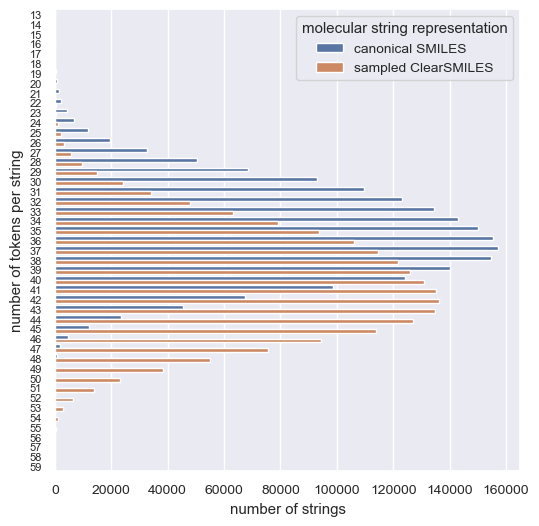

In [29]:
sns.set(rc={'figure.figsize':(6,6)})
sns.set(font_scale=0.90)

fig=sns.countplot(data=df_tokens_length,y="nb_tokens", hue="molecular string representation")
fig.set_xlabel("number of strings")
fig.set_ylabel("number of tokens per string")
fig.tick_params(axis='x', labelsize=10)
fig.tick_params(axis='y', labelsize=8)
plt.savefig("../../../Pictures/tokens_length.svg", format='svg')

In [30]:
df_tokens_length.groupby(by=["molecular string representation"])["nb_tokens"].quantile([0,.25,.5,.75,1])

molecular string representation      
canonical SMILES                 0.00    13.0
                                 0.25    32.0
                                 0.50    36.0
                                 0.75    39.0
                                 1.00    54.0
sampled ClearSMILES              0.00    13.0
                                 0.25    36.0
                                 0.50    40.0
                                 0.75    44.0
                                 1.00    59.0
Name: nb_tokens, dtype: float64

In [31]:
subset=df.query('nb_token_ClearSMILES<=58 & max_digit<=2')

In [32]:
subset=subset.rename(columns={"sampled_ClearSMILES":"smiles"})

In [33]:
subset

,nb_random,max_digit,lowest_mem_score,nb_unique_random_smiles,nb_lowest_max_digit_smiles,nb_equivalent_solution,ClearSMILES_set,random_gen_time,min_max_digit_time,mem_map_time,total_time,SMILES,SPLIT,canonical_smiles,smiles,nb_token_regular,nb_token_ClearSMILES
0,100000,1,0.906977,7614,5025,2,FC1=CC=C(F)C=C1NS(=O)(=O)C1=CC=C(F)C(F)=C1F_FC...,6.809037,0.023423,0.175887,7.008428,O=S(=O)(Nc1cc(F)ccc1F)c1ccc(F)c(F)c1F,train,O=S(=O)(Nc1cc(F)ccc1F)c1ccc(F)c(F)c1F,FC1=CC=C(F)C=C1NS(=O)(=O)C1=CC=C(F)C(F)=C1F,37,43
1,100000,1,0.829268,2544,1656,2,FC1=CC=C(F)C=C1NS(=O)(=O)C1C=CC=C(C=1)C#N_N#CC...,6.461382,0.007614,0.052121,6.521148,N#Cc1cccc(S(=O)(=O)Nc2cc(F)ccc2F)c1,test,N#Cc1cccc(S(=O)(=O)Nc2cc(F)ccc2F)c1,FC1=CC=C(F)C=C1NS(=O)(=O)C1C=CC=C(C=1)C#N,35,41
2,100000,1,0.853659,2544,1656,2,N#CC1=CC=C(C=C1)S(=O)(=O)NC1=CC(F)=CC=C1F_FC1=...,6.471750,0.007562,0.052288,6.531633,N#Cc1ccc(S(=O)(=O)Nc2cc(F)ccc2F)cc1,train,N#Cc1ccc(S(=O)(=O)Nc2cc(F)ccc2F)cc1,N#CC1=CC=C(C=C1)S(=O)(=O)NC1=CC(F)=CC=C1F,35,41
3,100000,2,0.955556,4820,3614,1,O1CCCOC2C1=CC=C(C=2)S(=O)(=O)NC1=CC(F)=CC=C1F,7.824565,0.013055,0.124897,7.962536,O=S(=O)(Nc1cc(F)ccc1F)c1ccc2c(c1)OCCCO2,train,O=S(=O)(Nc1cc(F)ccc1F)c1ccc2c(c1)OCCCO2,O1CCCOC2C1=CC=C(C=2)S(=O)(=O)NC1=CC(F)=CC=C1F,39,45
4,100000,1,0.857143,4463,2879,2,COC1=CC=C(OC)C=C1S(=O)(=O)NC1=CC(F)=CC=C1F_FC1...,6.936087,0.013249,0.097328,7.046707,COc1ccc(OC)c(S(=O)(=O)Nc2cc(F)ccc2F)c1,train,COc1ccc(OC)c(S(=O)(=O)Nc2cc(F)ccc2F)c1,COC1=CC=C(OC)C=C1S(=O)(=O)NC1=CC(F)=CC=C1F,38,42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1936957,100000,2,0.875000,2176,1688,1,C1CCCN2C1COC(C2)CNC(=O)NCC1C=CC=C(C=1)OC,16.224227,0.010762,0.102354,16.337362,COc1cccc(CNC(=O)NCC2CN3CCCCC3CO2)c1,train,COc1cccc(CNC(=O)NCC2CN3CCCCC3CO2)c1,C1CCCN2C1COC(C2)CNC(=O)NCC1C=CC=C(C=1)OC,35,40
1936958,100000,2,0.952381,4112,3256,3,C1CCCN2C1COC(C2)CNC(=O)NCC1C=C(F)C(C)=CC=1_C1C...,15.889686,0.020518,0.196105,16.106328,Cc1ccc(CNC(=O)NCC2CN3CCCCC3CO2)cc1F,train,Cc1ccc(CNC(=O)NCC2CN3CCCCC3CO2)cc1F,C1CCCN2C1COC(C2)CNC(=O)NCC1C=C(F)C(C)=CC=1,35,42
1936959,100000,2,0.875000,2080,1360,1,C1CCCN2C1COC(C2)CNC(=O)NC1=NN=C(S1)C1CC1,16.651164,0.009991,0.081478,16.742665,O=C(NCC1CN2CCCCC2CO1)Nc1nnc(C2CC2)s1,train,O=C(NCC1CN2CCCCC2CO1)Nc1nnc(C2CC2)s1,C1CCCN2C1COC(C2)CNC(=O)NC1=NN=C(S1)C1CC1,36,40
1936960,100000,1,0.790698,2112,736,8,C1C=CC=CC=1SCCNC(=O)C1C=NN(C=1C)C1C=CN=CC=1_C1...,15.300178,0.010769,0.045422,15.356399,Cc1c(C(=O)NCCSc2ccccc2)cnn1-c1ccncc1,test_scaffolds,Cc1c(C(=O)NCCSc2ccccc2)cnn1-c1ccncc1,C1C=CC=CC=1SCCNC(=O)C1C=NN(C=1C)C1C=CN=CC=1,36,43


In [34]:
subset["SPLIT"].unique()

array(['train', 'test', 'test_scaffolds'], dtype=object)

In [35]:
train_set=subset.query('SPLIT=="train"')
train_set.to_csv("../data/processed/sampled_Clearsmiles_train.csv",columns=["smiles"],index=False)

In [36]:
test_set=subset.query('SPLIT=="test"')
test_set.to_csv("../data/processed/sampled_Clearsmiles_test.csv",columns=["smiles"],index=False)

In [37]:
test_scaffolds_set=subset.query('SPLIT=="test_scaffolds"')
test_scaffolds_set.to_csv("../data/processed/sampled_Clearsmiles_test_scaffolds.csv",columns=["smiles"],index=False)

In [38]:
train_set["nb_token_ClearSMILES"].max()

58

In [39]:
test_set["nb_token_ClearSMILES"].max()

58

In [40]:
def find_biggest_digits(smiles :str):
    """
    find the biggest digits by iterating throught possible max digit possible and test if corresponding character is found in string
    """
    ### instantiate local variable
    max_digit=0 

    ### iterate through max digits possible solution
    for i in range(1,10):
        digit=10-i
        if smiles.find(str(digit))!=-1:
            max_digit=digit
            break
        else:
            pass
    
    return max_digit

In [41]:
with mp.Pool(NB_CORES) as pool:
    df["max_digit_canonical"]= pool.map(find_biggest_digits,df["canonical_smiles"])
    pool.close()
    pool.join()

In [42]:
digit_df= pd.DataFrame(data=[["canonical SMILES",digit] for digit in df["max_digit_canonical"]]+[["sampled ClearSMILES",digit] for digit in df["max_digit"]], columns=["molecular string representation", "max_digit"])

In [43]:
digit_df=digit_df[digit_df["max_digit"]>0]

In [44]:
def get_ring_size(smiles=str(),SMILES_REGEX=re.compile("(\[[^\]]+]|Br?|Cl?|N|O|S|P|F|I|b|c|n|o|s|p|\(|\)|\.|=|#|-|\+|\\\\|\/|_|:|~|@|\?|>|\*|\$|\%[0-9]{2}|[0-9])")):
    """
    use regular regular expression to decompose SMILES to tokens and mesure length of rings. 3 metrics are computed on ring size : min,max, range coef 
    """
    ###  instantiate variables 
    ring_index_dict={}
    ring_parameters_list=[]
    
    ### get token list from SMILES
    tokens_list= SMILES_REGEX.findall(smiles)

    ### iterate through tokens and indices
    for i,token in enumerate(tokens_list):
        if token.isdigit():
            if token in ring_index_dict:
                temp_dict= {
                    "digit" : token,
                    "matching_digit_distance" : i-ring_index_dict[token]
                }
                ring_parameters_list.append(temp_dict)
                ring_index_dict.pop(token)
            else:
                ring_index_dict[token]= i
    
    ### append 0 if no ring were detected
    if not ring_parameters_list:
        temp_dict= {
                    "digit" : 0,
                    "matching_digit_distance" : 0
                }
        ring_parameters_list.append(temp_dict)

    return ring_parameters_list


In [45]:
with mp.Pool(NB_CORES) as pool:
    results= pool.map(partial(get_ring_size,SMILES_REGEX=SMILES_REGEX),df["canonical_smiles"])
    pool.close()
    pool.join()

In [46]:
results= list(chain.from_iterable(results))

In [47]:
ring_df=pd.DataFrame(results)

In [48]:
ring_df["molecular string representation"]="canonical SMILES"

In [49]:
ring_df

,digit,matching_digit_distance,molecular string representation
0,1,9,canonical SMILES
1,1,12,canonical SMILES
2,2,9,canonical SMILES
3,1,30,canonical SMILES
4,2,9,canonical SMILES
...,...,...,...
5005774,1,6,canonical SMILES
5005775,2,6,canonical SMILES
5005776,1,12,canonical SMILES
5005777,1,11,canonical SMILES


In [50]:
with mp.Pool(mp.cpu_count()) as pool:
    results= pool.map(partial(get_ring_size,SMILES_REGEX=SMILES_REGEX),df["sampled_ClearSMILES"])
    pool.close()
    pool.join()

In [51]:
results= list(chain.from_iterable(results))

In [52]:
temp_df= pd.DataFrame(results)

In [53]:
temp_df["molecular string representation"]="sampled ClearSMILES"

In [54]:
ring_df= pd.concat([ring_df,temp_df],ignore_index=True)

In [55]:
ring_df

,digit,matching_digit_distance,molecular string representation
0,1,9,canonical SMILES
1,1,12,canonical SMILES
2,2,9,canonical SMILES
3,1,30,canonical SMILES
4,2,9,canonical SMILES
...,...,...,...
10011553,1,9,sampled ClearSMILES
10011554,1,7,sampled ClearSMILES
10011555,2,8,sampled ClearSMILES
10011556,1,9,sampled ClearSMILES


In [56]:
ring_df["digit"]=pd.to_numeric(ring_df["digit"])

In [57]:
ring_df=ring_df.query("digit>0")

In [58]:
contingency_table_list=[]
max_nb_ring=0
index_set= set()
column_set= set()
for unique_rep in ring_df["molecular string representation"].unique():
    subset= ring_df[ring_df["molecular string representation"]==unique_rep]
    contingency_table= pd.crosstab(index=subset['digit'], columns=subset["matching_digit_distance"])
    index_set.update(set(contingency_table.index))
    column_set.update(set(contingency_table.columns))
    contingency_table= np.log10(contingency_table)
    contingency_table.replace(-np.inf, np.nan, inplace=True)
    temp_max= contingency_table.max().max()
    if temp_max > max_nb_ring:
        max_nb_ring=temp_max
    contingency_table_list.append(contingency_table)
    

/home/etienne-reboul/anaconda3/envs/ClearSMILES/lib/python3.10/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)
/home/etienne-reboul/anaconda3/envs/ClearSMILES/lib/python3.10/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log10
  result = func(self.values, **kwargs)


In [59]:
sns.set(rc={'figure.figsize':(6,3)})
sns.set(font_scale=0.90)

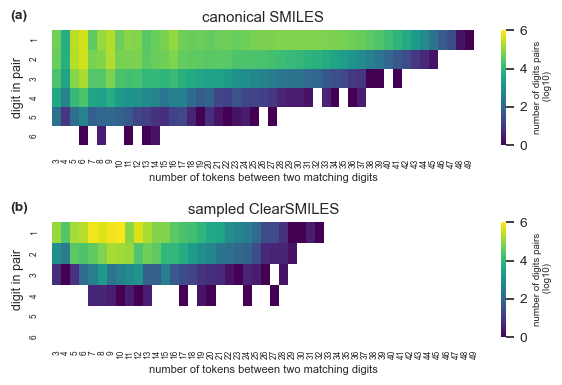

In [60]:
### make the same x and y ticks 
sorted_xticks= sorted(list(column_set))
sorted_yticks= sorted(list(index_set))

### set the number of row and columns needed for the plot 
nb_row= 2
nb_col=1

# Define the custom colorbar range
custom_vmin = 0
custom_vmax = np.ceil(max_nb_ring)

# Set up subplots
fig, axes = plt.subplots(nrows= nb_row, ncols=nb_col, figsize=(6, 2*nb_row))

for i,unique_rep in enumerate(ring_df["molecular string representation"].unique()):
    subplot_title=unique_rep
    
    # Use Seaborn to plot the heatmap on the current subplot
    sns.heatmap(contingency_table_list[i], 
                annot=False, 
                cmap='viridis',
                ax=axes[i], 
                cbar=True,
                xticklabels= sorted_xticks,
                yticklabels=sorted_yticks,
                vmin=custom_vmin, 
                vmax=custom_vmax,
                annot_kws={'size': 5},
                cbar_kws={'label': 'number of digits pairs\n (log10)'}
                )
    
    
    # Set titles and labels
    axes[i].set_facecolor("white")
    axes[i].set_title(subplot_title)
    axes[i].set_xlabel('number of tokens between two matching digits',fontsize=8)
    axes[i].tick_params(axis="x", labelsize=6)
    axes[i].set_ylabel('digit in pair',fontsize=9)
    axes[i].tick_params(axis="y", labelsize=6)
    
    axes[i].figure.axes[-1].yaxis.label.set_size(7)

subplot_labels = ["(a)","(b)"]
for ax, label in zip(axes.ravel(), subplot_labels):
    ax.text(-0.1, 1.1, label, transform=ax.transAxes, fontsize=10, fontweight="bold")



# Adjust layout
plt.tight_layout()
plt.savefig("../../../Pictures/digit_contingency_table.svg", format="svg")
plt.show()

In [61]:
ring_df["mol_rep"]=ring_df["molecular string representation"]

/tmp/ipykernel_6736/3135054572.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ring_df["mol_rep"]=ring_df["molecular string representation"]


In [62]:
len(ring_df.query('matching_digit_distance>25 & mol_rep=="canonical SMILES"'))/len(ring_df.query('matching_digit_distance>25 & mol_rep=="sampled ClearSMILES"'))

11962.128205128205

In [63]:
(len(df)-len(df.query('max_digit>2')))/len(df)*100

99.72167755485137

In [64]:
def find_nb_branches(smiles=str()):
    return smiles.count("(")

In [65]:
with mp.Pool(mp.cpu_count()) as pool:
    df["regular_nb_branches"]=pool.map(find_nb_branches,df["canonical_smiles"])
    pool.close()
    pool.join()

In [66]:
with mp.Pool(mp.cpu_count()) as pool:
    df["ClearSMILES_nb_branches"]=pool.map(find_nb_branches,df["sampled_ClearSMILES"])
    pool.close()
    pool.join()

In [67]:
df['delta_branches']= df["ClearSMILES_nb_branches"]- df["regular_nb_branches"]

In [68]:
delta_df=df["delta_branches"].value_counts(normalize=True)

In [69]:
delta_df.sort_index(inplace=True)
delta_df= delta_df*100

In [70]:
delta_df

delta_branches
-3     0.003356
-2     0.459018
-1    11.723823
 0    74.900385
 1    11.690162
 2     1.183141
 3     0.039495
 4     0.000620
Name: proportion, dtype: float64

In [71]:
df_branches= pd.DataFrame(data=[["canonical SMILES",nb_branches] for nb_branches in df["regular_nb_branches"]]+[["sampled ClearSMILES",nb_branches] 
                                                                                                                for nb_branches in df["ClearSMILES_nb_branches"]],
                                                                                                                columns=["molecular string representation","nb_branches"])

In [72]:
df_branches

,molecular string representation,nb_branches
0,canonical SMILES,5
1,canonical SMILES,4
2,canonical SMILES,4
3,canonical SMILES,4
4,canonical SMILES,5
...,...,...
3873919,sampled ClearSMILES,3
3873920,sampled ClearSMILES,4
3873921,sampled ClearSMILES,3
3873922,sampled ClearSMILES,2


In [73]:
def compute_branch_size(smiles : str , data_augmentation : str, smiles_regex :re.compile) -> list[dict]:
    """
    use regular regular expression to decompose SMILES to tokens and mesure length of branches and their depth 
    input :
    smiles (string): a valid SMILES string 
    SMILES_REGEX (compiled regex):  the compiled pattern used to tokenize the SMILES 
    output : 
    branch_results (list of dicts): the list contain a dict per branch with 
    """
    # declare local variable
    branch_begin_index_list=[]
    branch_results=[]

    # get token list from SMILES
    tokens_list= smiles_regex.findall(smiles)

    # iterate through tokens
    for i,token in enumerate(tokens_list):
        if token=="(":
            branch_begin_index_list.append(i)
        elif token==")":
            temp_dict= {
                "smiles" : smiles,
                "molecular string representation" : data_augmentation,
                "branches length" : i-branch_begin_index_list[-1]
            }
            branch_results.append(temp_dict)
            branch_begin_index_list.pop()

    return branch_results
    

In [74]:
df

,nb_random,max_digit,lowest_mem_score,nb_unique_random_smiles,nb_lowest_max_digit_smiles,nb_equivalent_solution,ClearSMILES_set,random_gen_time,min_max_digit_time,mem_map_time,...,SMILES,SPLIT,canonical_smiles,sampled_ClearSMILES,nb_token_regular,nb_token_ClearSMILES,max_digit_canonical,regular_nb_branches,ClearSMILES_nb_branches,delta_branches
0,100000,1,0.906977,7614,5025,2,FC1=CC=C(F)C=C1NS(=O)(=O)C1=CC=C(F)C(F)=C1F_FC...,6.809037,0.023423,0.175887,...,O=S(=O)(Nc1cc(F)ccc1F)c1ccc(F)c(F)c1F,train,O=S(=O)(Nc1cc(F)ccc1F)c1ccc(F)c(F)c1F,FC1=CC=C(F)C=C1NS(=O)(=O)C1=CC=C(F)C(F)=C1F,37,43,1,5,5,0
1,100000,1,0.829268,2544,1656,2,FC1=CC=C(F)C=C1NS(=O)(=O)C1C=CC=C(C=1)C#N_N#CC...,6.461382,0.007614,0.052121,...,N#Cc1cccc(S(=O)(=O)Nc2cc(F)ccc2F)c1,test,N#Cc1cccc(S(=O)(=O)Nc2cc(F)ccc2F)c1,FC1=CC=C(F)C=C1NS(=O)(=O)C1C=CC=C(C=1)C#N,35,41,2,4,4,0
2,100000,1,0.853659,2544,1656,2,N#CC1=CC=C(C=C1)S(=O)(=O)NC1=CC(F)=CC=C1F_FC1=...,6.471750,0.007562,0.052288,...,N#Cc1ccc(S(=O)(=O)Nc2cc(F)ccc2F)cc1,train,N#Cc1ccc(S(=O)(=O)Nc2cc(F)ccc2F)cc1,N#CC1=CC=C(C=C1)S(=O)(=O)NC1=CC(F)=CC=C1F,35,41,2,4,4,0
3,100000,2,0.955556,4820,3614,1,O1CCCOC2C1=CC=C(C=2)S(=O)(=O)NC1=CC(F)=CC=C1F,7.824565,0.013055,0.124897,...,O=S(=O)(Nc1cc(F)ccc1F)c1ccc2c(c1)OCCCO2,train,O=S(=O)(Nc1cc(F)ccc1F)c1ccc2c(c1)OCCCO2,O1CCCOC2C1=CC=C(C=2)S(=O)(=O)NC1=CC(F)=CC=C1F,39,45,2,4,4,0
4,100000,1,0.857143,4463,2879,2,COC1=CC=C(OC)C=C1S(=O)(=O)NC1=CC(F)=CC=C1F_FC1...,6.936087,0.013249,0.097328,...,COc1ccc(OC)c(S(=O)(=O)Nc2cc(F)ccc2F)c1,train,COc1ccc(OC)c(S(=O)(=O)Nc2cc(F)ccc2F)c1,COC1=CC=C(OC)C=C1S(=O)(=O)NC1=CC(F)=CC=C1F,38,42,2,5,4,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1936957,100000,2,0.875000,2176,1688,1,C1CCCN2C1COC(C2)CNC(=O)NCC1C=CC=C(C=1)OC,16.224227,0.010762,0.102354,...,COc1cccc(CNC(=O)NCC2CN3CCCCC3CO2)c1,train,COc1cccc(CNC(=O)NCC2CN3CCCCC3CO2)c1,C1CCCN2C1COC(C2)CNC(=O)NCC1C=CC=C(C=1)OC,35,40,3,2,3,1
1936958,100000,2,0.952381,4112,3256,3,C1CCCN2C1COC(C2)CNC(=O)NCC1C=C(F)C(C)=CC=1_C1C...,15.889686,0.020518,0.196105,...,Cc1ccc(CNC(=O)NCC2CN3CCCCC3CO2)cc1F,train,Cc1ccc(CNC(=O)NCC2CN3CCCCC3CO2)cc1F,C1CCCN2C1COC(C2)CNC(=O)NCC1C=C(F)C(C)=CC=1,35,42,3,2,4,2
1936959,100000,2,0.875000,2080,1360,1,C1CCCN2C1COC(C2)CNC(=O)NC1=NN=C(S1)C1CC1,16.651164,0.009991,0.081478,...,O=C(NCC1CN2CCCCC2CO1)Nc1nnc(C2CC2)s1,train,O=C(NCC1CN2CCCCC2CO1)Nc1nnc(C2CC2)s1,C1CCCN2C1COC(C2)CNC(=O)NC1=NN=C(S1)C1CC1,36,40,2,2,3,1
1936960,100000,1,0.790698,2112,736,8,C1C=CC=CC=1SCCNC(=O)C1C=NN(C=1C)C1C=CN=CC=1_C1...,15.300178,0.010769,0.045422,...,Cc1c(C(=O)NCCSc2ccccc2)cnn1-c1ccncc1,test_scaffolds,Cc1c(C(=O)NCCSc2ccccc2)cnn1-c1ccncc1,C1C=CC=CC=1SCCNC(=O)C1C=NN(C=1C)C1C=CN=CC=1,36,43,2,2,2,0


In [75]:
# prepare partial function for data multiprocessing  of branch size computation
branch_compute= partial(compute_branch_size,smiles_regex= SMILES_REGEX,data_augmentation="canonical SMILES")

# execute multprocessing
with mp.Pool(NB_CORES) as pool:
    results= pool.map(branch_compute,df["canonical_smiles"])

# repeat process but for clearsmiles
branch_compute= partial(compute_branch_size,smiles_regex= SMILES_REGEX,data_augmentation="sampled ClearSMILES")

# execute multprocessing
with mp.Pool(NB_CORES) as pool:
    results.extend(pool.map(branch_compute,df["sampled_ClearSMILES"])) 


In [76]:
branch_size_df= pd.DataFrame(data=chain.from_iterable(results))


In [77]:
branch_size_df

,smiles,molecular string representation,branches length
0,O=S(=O)(Nc1cc(F)ccc1F)c1ccc(F)c(F)c1F,canonical SMILES,3
1,O=S(=O)(Nc1cc(F)ccc1F)c1ccc(F)c(F)c1F,canonical SMILES,2
2,O=S(=O)(Nc1cc(F)ccc1F)c1ccc(F)c(F)c1F,canonical SMILES,14
3,O=S(=O)(Nc1cc(F)ccc1F)c1ccc(F)c(F)c1F,canonical SMILES,2
4,O=S(=O)(Nc1cc(F)ccc1F)c1ccc(F)c(F)c1F,canonical SMILES,2
...,...,...,...
13341887,C1CCCN2C1COC(C2)CNC(=O)NC1=NN=C(S1)C1CC1,sampled ClearSMILES,3
13341888,C1C=CC=CC=1SCCNC(=O)C1C=NN(C=1C)C1C=CN=CC=1,sampled ClearSMILES,3
13341889,C1C=CC=CC=1SCCNC(=O)C1C=NN(C=1C)C1C=CN=CC=1,sampled ClearSMILES,5
13341890,C1CCCN2C1COC(C2)CNC(=O)NC1=CC=CC2C1=NC=CC=2,sampled ClearSMILES,3


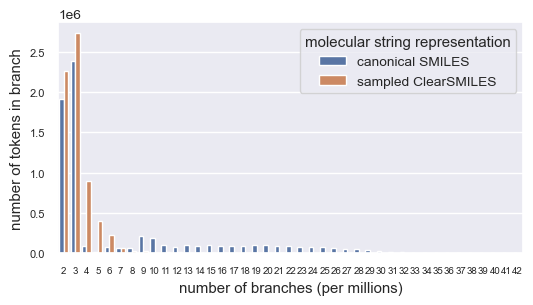

In [78]:

fig=sns.countplot(data=branch_size_df,x="branches length", hue="molecular string representation")
fig.set_xlabel("number of branches (per millions)")
fig.set_ylabel("number of tokens in branch")
fig.tick_params(axis='x', labelsize=7)
fig.tick_params(axis='y', labelsize=8)
plt.savefig("../../../Pictures/branches_length.svg", format='svg')

In [79]:
def get_semantic_mem_score(smiles :str, data_augmentation : str,smiles_regex :re.compile) -> dict: 
    """
    This function will generate a semantic memory map of a SMILES, i.e the number of semantic feature open for every token. 
    Semantic feature include  branches and  rings 
        smiles (string) : a valid SMILES 
        SMILES_REGEX (compiled regular expression): compiled regular expression used to tokenize SMILES
        bonds_set (set of strings): a set containing all the bonds tokens
    output :
        results_dict  (dict):   contains smiles, data augmentation and memory score
    """

    ### declare local variables
    tokens_list=smiles_regex.findall(smiles)
    mem_map= np.zeros(len(tokens_list),dtype=int)
    digit_set=set()

    ### iterate throught tokens 
    for i,token in enumerate(tokens_list):
        if token=="(":
            mem_map[i]+= 1
        elif token==")":
            mem_map[i]-=1
        elif token.isdigit():
            if token in digit_set:
                digit_set.remove(token)
                mem_map[i]-= 1
            else:
                digit_set.add(token)
                mem_map[i]+= 1

    # package results
    result_dict={
        "smiles" : smiles,
        "molecular string representation" : data_augmentation,
        "mem_score" : np.mean(mem_map.cumsum())
    }
    
    return result_dict

In [80]:
# prepare partial object for multiprocessing
mp_mem_score=partial(get_semantic_mem_score,smiles_regex=SMILES_REGEX,data_augmentation="canonical SMILES")

with mp.Pool(NB_CORES) as pool:
    results= pool.map(mp_mem_score,df["canonical_smiles"])


mp_mem_score=partial(get_semantic_mem_score,smiles_regex=SMILES_REGEX,data_augmentation="sampled ClearSMILES")
with mp.Pool(NB_CORES) as pool:
    results.extend(pool.map(mp_mem_score,df["sampled_ClearSMILES"])) 


In [81]:
df_mem_score= pd.DataFrame(results)

In [82]:
df_mem_score

,smiles,molecular string representation,mem_score
0,O=S(=O)(Nc1cc(F)ccc1F)c1ccc(F)c(F)c1F,canonical SMILES,1.189189
1,N#Cc1cccc(S(=O)(=O)Nc2cc(F)ccc2F)c1,canonical SMILES,2.000000
2,N#Cc1ccc(S(=O)(=O)Nc2cc(F)ccc2F)cc1,canonical SMILES,2.000000
3,O=S(=O)(Nc1cc(F)ccc1F)c1ccc2c(c1)OCCCO2,canonical SMILES,1.282051
4,COc1ccc(OC)c(S(=O)(=O)Nc2cc(F)ccc2F)c1,canonical SMILES,2.026316
...,...,...,...
3873919,C1CCCN2C1COC(C2)CNC(=O)NCC1C=CC=C(C=1)OC,sampled ClearSMILES,0.875000
3873920,C1CCCN2C1COC(C2)CNC(=O)NCC1C=C(F)C(C)=CC=1,sampled ClearSMILES,0.952381
3873921,C1CCCN2C1COC(C2)CNC(=O)NC1=NN=C(S1)C1CC1,sampled ClearSMILES,0.875000
3873922,C1C=CC=CC=1SCCNC(=O)C1C=NN(C=1C)C1C=CN=CC=1,sampled ClearSMILES,0.790698


In [83]:
step=0.1
df_mem_score.groupby(by=["molecular string representation"])["mem_score"].quantile(np.arange(0,1+step,step))

molecular string representation     
canonical SMILES                 0.0    0.310345
                                 0.1    0.846154
                                 0.2    1.102564
                                 0.3    1.307692
                                 0.4    1.515152
                                 0.5    1.710526
                                 0.6    1.878788
                                 0.7    2.057143
                                 0.8    2.294118
                                 0.9    2.600000
                                 1.0    4.913043
sampled ClearSMILES              0.0    0.250000
                                 0.1    0.696970
                                 0.2    0.750000
                                 0.3    0.785714
                                 0.4    0.818182
                                 0.5    0.850000
                                 0.6    0.882353
                                 0.7    0.918367
                                

In [84]:
df_mem_score.groupby(by=["molecular string representation"])["mem_score"].std()

molecular string representation
canonical SMILES       0.661445
sampled ClearSMILES    0.134502
Name: mem_score, dtype: float64

In [85]:
df_mem_score.groupby(by=["molecular string representation"])["mem_score"].mean()

molecular string representation
canonical SMILES       1.720709
sampled ClearSMILES    0.858267
Name: mem_score, dtype: float64

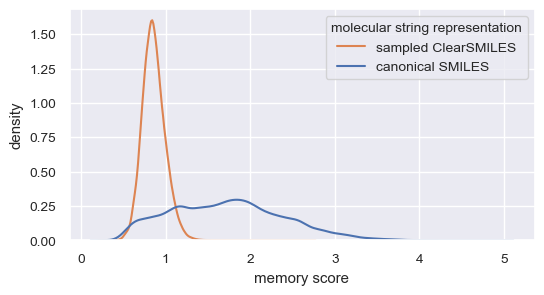

In [86]:
fig = sns.kdeplot(data=df_mem_score, x="mem_score", hue="molecular string representation", bw_method=0.1)

# Modify x-axis label
fig.set(xlabel="memory score")

# Modify y-axis label
fig.set(ylabel="density")

# Explicitly set legend labels

legend=fig.legend(title="molecular string representation", labels=['sampled ClearSMILES','canonical SMILES'], fontsize=10)

# Adjust the size of the legend title
legend.get_title().set_fontsize(10) 

# sns.move_legend(fig, "upper left", bbox_to_anchor=(0.37, 0.95))
plt.savefig("../../../Pictures/mem_score_kdeplot.svg", format='svg')
plt.show()

/tmp/ipykernel_6736/568497940.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='upper left', bbox_to_anchor=(0.5, 0.5))  # You can adjust the bbox_to_anchor values as needed


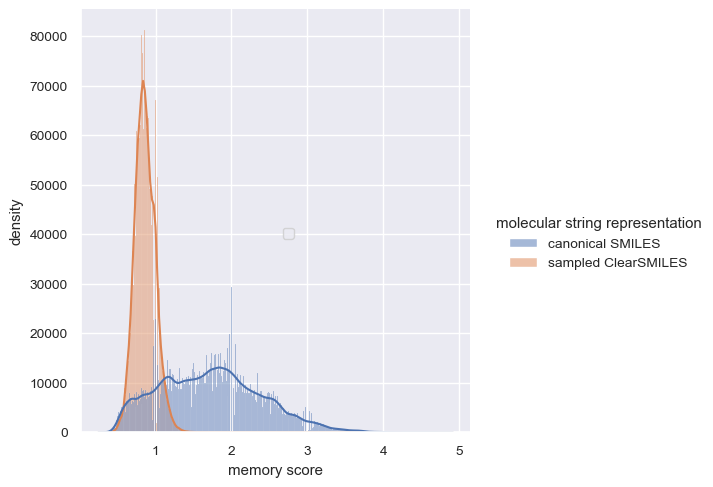

In [87]:
# Your existing code
fig = sns.displot(data=df_mem_score, x="mem_score", hue="molecular string representation", kde=True)

# Modify x-axis label
fig.set(xlabel="memory score")

# Modify y-axis label
fig.set(ylabel="density")

# Explicitly set legend labels
plt.legend(title="molecular string representation", labels=['sampled ClearSMILES', 'canonical SMILES'], fontsize=6)

# Use this to manually position the legend in the center
plt.legend(loc='upper left', bbox_to_anchor=(0.5, 0.5))  # You can adjust the bbox_to_anchor values as needed

# Save the figure
plt.savefig("../../../Pictures/mem_score_kdeplot.svg", format='svg')

# Show the plot
plt.show()


In [88]:
sns.set(rc={'figure.figsize':(20,8.27)})
sns.set(font_scale=2)

In [89]:
def find_main_chain_length(smiles= str(),SMILES_REGEX=re.compile("(\[[^\]]+]|Br?|Cl?|N|O|S|P|F|I|b|c|n|o|s|p|\(|\)|\.|=|#|-|\+|\\\\|\/|_|:|~|@|\?|>|\*|\$|\%[0-9]{2}|[0-9])")): 
    """
    THis function wil count the number of tokens that are not in branches. Simply put , it will not count tokens that are comprised between two parenthesis
    input :
        smiles (string),  a valid smiles 
        SMILES_REGEX (compiled regex), compiled regex used to tokenize SMILES 
    output : 
        length_main_chain (integer), the number of tokens in the main chain 
    """
    ### declare local variable 
    tokens_list= SMILES_REGEX.findall(smiles)
    branch_status= 0
    length_main_chain=0

    
    ### iterate through tokens 
    for token in tokens_list:

        ### check for parenthesis parenthesis 
        if token=="(":
            branch_status+=1
        elif token ==")":
            branch_status-=1
        else:
            ### check branch status to know if you need to count token 
            if branch_status==0:
                length_main_chain+=1
            else:
                pass

    return length_main_chain


In [90]:
with mp.Pool(mp.cpu_count()) as pool:
    df["canonical_main_chain_length"]= pool.map(partial(find_main_chain_length,SMILES_REGEX=SMILES_REGEX),df["canonical_smiles"])
    pool.close()
    pool.join()

In [91]:
with mp.Pool(mp.cpu_count()) as pool:
    df["max_main_chain_length"]= pool.map(partial(find_main_chain_length,SMILES_REGEX=SMILES_REGEX),df["sampled_ClearSMILES"])
    pool.close()
    pool.join()

In [92]:
df["canonical_main_chain_length"]= df["canonical_main_chain_length"]/df["nb_token_regular"]

In [93]:
df["max_main_chain_length"]=df["max_main_chain_length"]/df["nb_token_ClearSMILES"]

In [94]:
df_main_chain= pd.DataFrame(data=[["canonical SMILES",main_chain_length] for main_chain_length in df["canonical_main_chain_length"]]+[["sampled ClearSMILES",main_chain_length] for main_chain_length in df["max_main_chain_length"]],columns=["molecular string representation","main_chain_length"])

In [95]:
sns.set(rc={'figure.figsize':(6,3)})
sns.set(font_scale=0.80)

In [96]:
sns.set(font_scale=1)

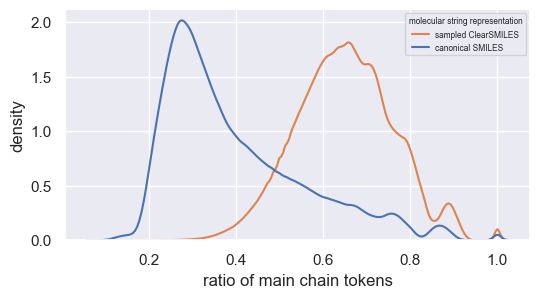

In [97]:
fig = sns.kdeplot(data=df_main_chain, x="main_chain_length", hue="molecular string representation")

# Modify x-axis label
fig.set(xlabel="ratio of main chain tokens")

# Modify y-axis label
fig.set(ylabel="density")

# Explicitly set legend labels

legend=fig.legend(title="molecular string representation", labels=[ 'sampled ClearSMILES','canonical SMILES'], fontsize=6)

# Adjust the size of the legend title
legend.get_title().set_fontsize(6) 

# sns.move_legend(fig, "upper left", bbox_to_anchor=(0.37, 0.95))
plt.savefig("../../../Pictures/main_chain_size.svg", format='svg')
plt.show()

/tmp/ipykernel_6736/2312343593.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[1].legend()
/tmp/ipykernel_6736/2312343593.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axes[2].legend()


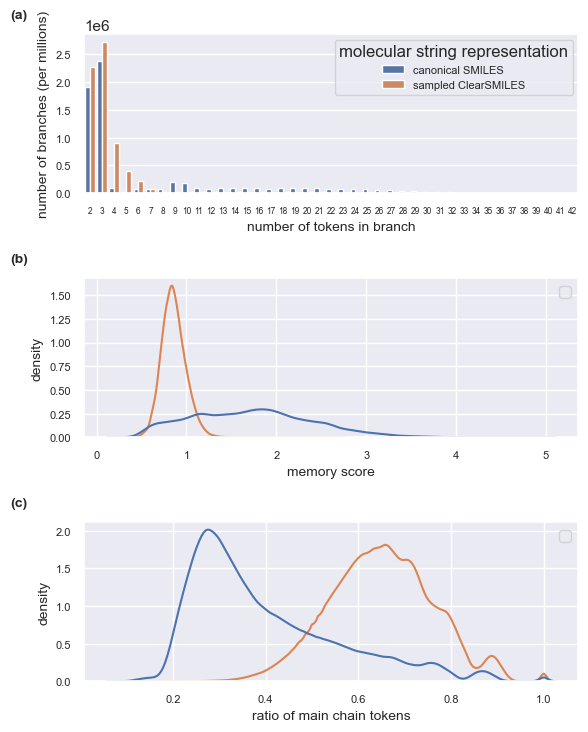

In [115]:
# Path to save the file
path2file = "../../../Pictures/ClearSMILES_panel_figure.svg"

# Compute the number of rows needed
nb_row = 3
nb_col = 1

# Set up subplots
fig, axes = plt.subplots(nrows=nb_row, ncols=nb_col, figsize=(6, 2.5*nb_row))

# First subplot
sns.countplot(data=branch_size_df, x="branches length", hue="molecular string representation", ax=axes[0])
axes[0].set_ylabel("number of branches (per millions)", fontsize=10)
axes[0].set_xlabel("number of tokens in branch", fontsize=10)
axes[0].tick_params(axis='x', labelsize=6)
axes[0].tick_params(axis='y', labelsize=8)
axes[0].legend(title="molecular string representation", labels=[ 'canonical SMILES','sampled ClearSMILES'], fontsize=8)
legend.get_title().set_fontsize(8) 

# Second subplot
sns.kdeplot(data=df_mem_score, x="mem_score", hue="molecular string representation", bw_method=0.1, ax=axes[1])
axes[1].set_xlabel("memory score", fontsize=10)
axes[1].set_ylabel("density", fontsize=10)
axes[1].tick_params(axis='x', labelsize=8)
axes[1].tick_params(axis='y', labelsize=8)
axes[1].legend()
legend.get_title().set_fontsize(8) 

# Third subplot (Placeholder, replace with your actual plot)
fig = sns.kdeplot(data=df_main_chain, x="main_chain_length", hue="molecular string representation", ax=axes[2])
axes[2].set_xlabel("ratio of main chain tokens", fontsize=10)
axes[2].set_ylabel("density", fontsize=10)
axes[2].tick_params(axis='x', labelsize=8)
axes[2].tick_params(axis='y', labelsize=8)
axes[2].legend()
legend.get_title().set_fontsize(8) 

# Subplot labels
subplot_labels = ["(a)", "(b)", "(c)"]
for ax, label in zip(axes.ravel(), subplot_labels):
    ax.text(-0.15, 1.1, label, transform=ax.transAxes, fontsize=10, fontweight="bold")

# Adjust layout
plt.tight_layout()
plt.savefig(path2file, format="svg")
plt.show()


In [120]:
 - 3

1411

In [124]:
int(('0' + '7') * 2)

707

In [123]:
( * 2)

1414

In [119]:
liste = list(range(10))
for i in range(len(liste)):
    print(f"{' ' * i}{-i}")

0
 -1
  -2
   -3
    -4
     -5
      -6
       -7
        -8
         -9


In [99]:
adam_mol=Chem.MolFromSmiles("C1C2CC3CC1CC(C2)C3")

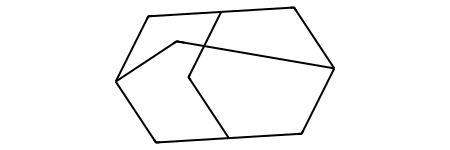

In [100]:
adam_mol

In [101]:
def find_substruct(smiles : str, query_mol : Chem.Mol)-> bool: 
    """ this function search a pattern in a mol using rdkit mol object 
    Args:
        smiles (str):  smiles of the molecule to be search
        query_mol (Chem.Mol): Mol object containing parten

    Returns:
        bool:  Results of the query 
    """
    ### fuck that 
    mol= Chem.MolFromSmiles(smiles)

    return mol.HasSubstructMatch(query_mol)

In [102]:
mp_part= partial(find_substruct,query_mol=adam_mol)
with mp.Pool(mp.cpu_count()-4) as pool:
    results=  pool.map(mp_part,df.query("max_digit>2")["sampled_ClearSMILES"])


In [103]:
np.sum(results)/len(results)

0.5386755703951029

In [104]:
inversed_results= [True if not result else False for result in results ]

In [105]:
df.query("max_digit>2")["sampled_ClearSMILES"][inversed_results]

2526               C(C)S(=O)(=O)NCCNC(=O)N1CC2CC3CC1CC(C2)C3
3906               C1=CC=C2C3=C1CCC3=CC=C2C(=O)NC1=NN=C(S1)C
4116                 C1C=COC=1CNC(=O)C1=CC=C2CCC3=C2C1=CC=C3
4470           C1CCCCCN1S(=O)(=O)C1=CC=C2C3C1=CC=CC=3C(N2)=O
4636          O=C1C2=CC=CC=C2OC23N1CCCN2C(=O)C1C(O3)=CC=CC=1
                                 ...                        
1932280    C1=CC=CC=C1CNS(=O)(=O)C1=CC=C2C3C1=CC=CC=3C(N2)=O
1932566         C1CCCCN1S(=O)(=O)C1=CC=C2C3C1=CC=CC=3C(S2)=O
1933101              O=C1C(=O)N2C3=C1C=C(OCC)C=C3C(C)CC2(C)C
1933238           C(C)COC(=O)C1C2C=CC3(O2)C1C(=O)N(C3)CC(C)C
1933676      C1C=CC2CCN3C=2C=1C(O)=C(C3=O)C(=O)NC1=NC=CC=C1O
Name: sampled_ClearSMILES, Length: 2487, dtype: object

In [106]:
tropane_core= Chem.MolFromSmiles("N1CC2CC3CC1CC(C2)C3")

In [107]:
mp_part= partial(find_substruct,query_mol=tropane_core)
with mp.Pool(mp.cpu_count()-4) as pool:
    results_tropane=  pool.map(mp_part,df.query("max_digit>2")["sampled_ClearSMILES"])


In [108]:
tropane_adam_results= [ True if adam_stat or tropane_stat else False for adam_stat,tropane_stat in zip(results,results_tropane)]

In [109]:
len(df.query("max_digit>2")["sampled_ClearSMILES"][tropane_adam_results])

3041

In [110]:
df.query("max_digit>2")["sampled_ClearSMILES"].shape[0]

5391

In [111]:
quantile_list=np.arange(0.,1.1,.1)

In [112]:
df_main_chain[df_main_chain["main_chain_length"]>0.8].groupby(by=["molecular string representation"]).count()

,main_chain_length
molecular string representation,
canonical SMILES,37753
sampled ClearSMILES,158917


In [113]:
df_main_chain.groupby(by=["molecular string representation"])["main_chain_length"].quantile(quantile_list)

molecular string representation     
canonical SMILES                 0.0    0.083333
                                 0.1    0.236842
                                 0.2    0.264706
                                 0.3    0.289474
                                 0.4    0.315789
                                 0.5    0.350000
                                 0.6    0.392857
                                 0.7    0.450000
                                 0.8    0.527778
                                 0.9    0.641026
                                 1.0    1.000000
sampled ClearSMILES              0.0    0.138889
                                 0.1    0.510204
                                 0.2    0.555556
                                 0.3    0.590909
                                 0.4    0.621622
                                 0.5    0.650000
                                 0.6    0.675676
                                 0.7    0.707317
                                